Load Forecasting in Power Systems using Graph Recurrent Neural Networks
=========================================
## Overview
In this notebook I put together some of the ideas I had regarding the use of Graph Neural Networks (GNNs) to forecast load and generation profiles in an electric grid. I trained a simple RNN to see that we can use AI to improve forecast. I implemented in in Tensorflow (sorry for not using PyTorch) since I am more familiar with it for the time being. 

The first part of the notebook is related to download some of the publicly available data from New York Independent System Operator (NYISO), which is the state agency responsible for the operation of the transmission system in NY (think of that agency as some sort of toll agency which needs to know how many cars will go on the highways for planning a satisfactory operation). Albeit the solution of the load forecasting problem is beyond the scope of the internship, we could use this as a motivation for exploring forecasting techniques based on GNNs.

With Luigi, we have found out that there was a huge mismatch between forecast and actual data which unveils the inaccuracy of the forecasting models. This came into the darkness when Gov. Cuomo issued the first stay-at-home order in mid-March. 

In this first cell, some functions from our previous work are used to download data from the NYISO website. The scripts download and organize all historical records from 2016 onwards. I use such a long time horizon to have enough training, testing and validation data for the RNN.

In [2]:
from download_nyiso_data import *
from get_weekly_behavior import *
from visualize_load_forecast import *
from compare_weekly_behavior import *

download_nyiso_data(start_year = 2016, destination_folder = "load_data", print_info = False)

The cell below uses a function to visualize the data from a specific day (`mm/dd/yyyy`) in one of the regions of the NYS grid (the NYS grid is divided into 13 subareas for in-depth studies). You could use `N.Y.C.` for the City, or `CENTRAL` for Albany, Troy and surroundings. `NYISO` shows the aggregated load. It is simple to se that the models have an inaccuracy of 1000-2000 MW peak which is not admissible for operating a power grid.

/Users/sadorador/miniconda3/envs/sd_dev_tf/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


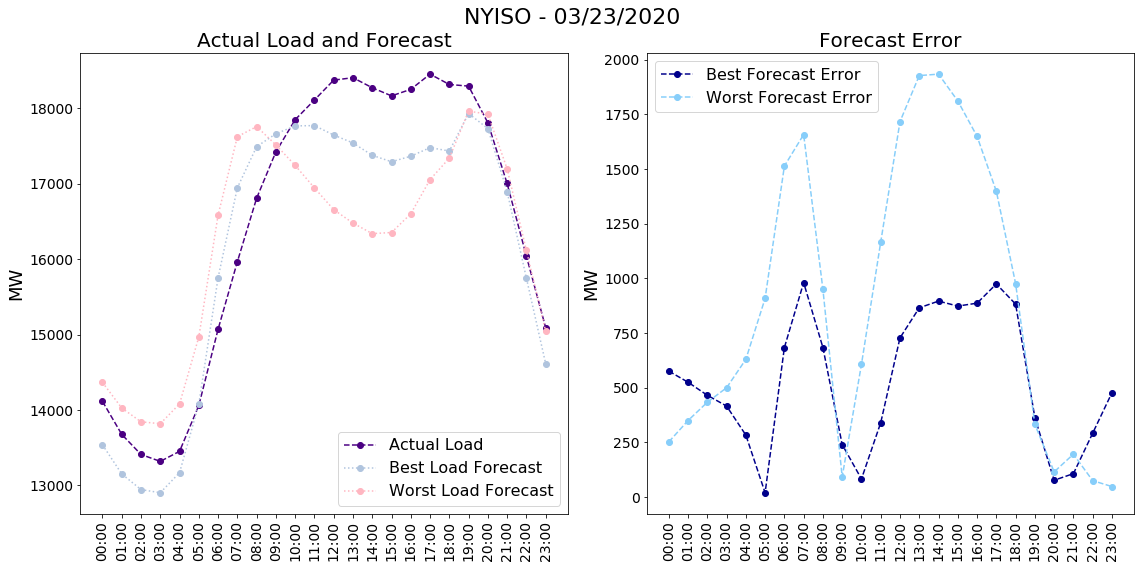

In [3]:
_, _, _, _ = visualize_load_forecast("03/23/2020", "NYISO", data_path = "load_data", show_plot = True)

Nevertheless, we have found that even in normal situation they have a forecast error.

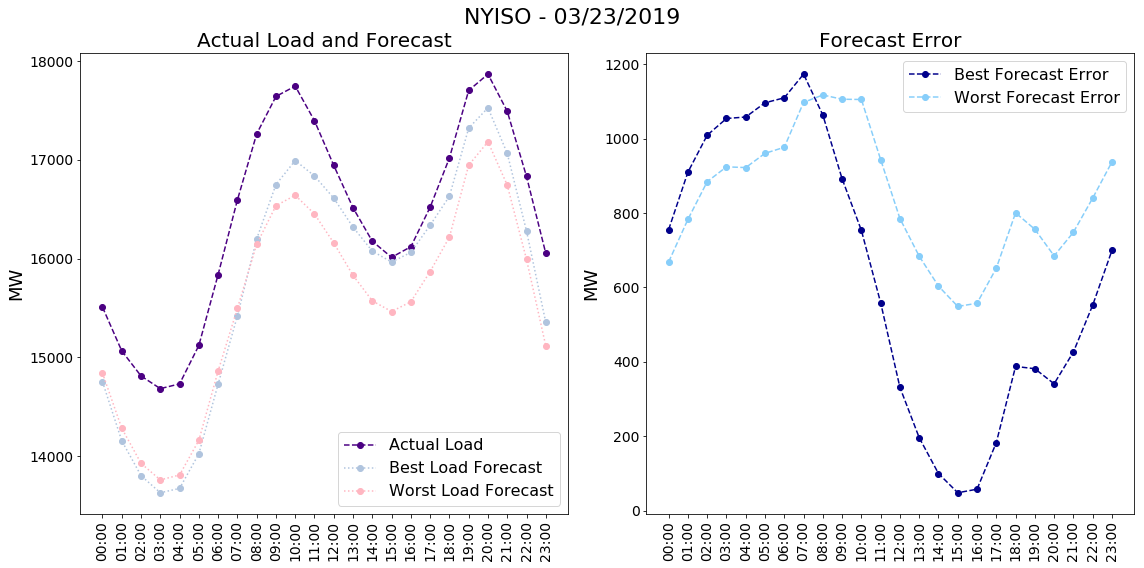

In [4]:
_, _, _, _ = visualize_load_forecast("03/23/2019", "NYISO", data_path = "load_data", show_plot = True)

The proof of concept here is to use the data for all week (hourly-basis) to predict the load profile for the next day. This is a time-series forecasting problem where we want to predict the next 24 values. I expect the performance not to be as good as the actual forecasting models since they are constructed with more information (5-minute basis updates vs. hourly updates). However, my conjecture is that even with a simple RNN structure we can get close to the actual behavior.

The cell below is responsible for organizing and preprocessing the data.

In [227]:
import pandas as pd

def allmondays(year):
    return pd.date_range(start=str(year), end=str(year+1), 
                         freq='W-MON').strftime('%m/%d/%Y').tolist()

mondays_last_3years = []

for year in [2017, 2018, 2019]:
    mondays_last_3years.extend(allmondays(year))

# Managing missing entries with a Pandas DataFrame
actual_load_data = pd.DataFrame(columns = mondays_last_3years)
    
for n_m, monday in enumerate(mondays_last_3years):
    _, actual_load, _, _ = get_weekly_behavior(monday, "NYISO", 
                                                                data_path = "load_data", show_plot = False)
    if len(actual_load) < 168:
        # Skipping incomplete data files
        continue
    else:
        # Adding normalized load data (ad-hoc normalization)
        actual_load_data[monday] = np.array(actual_load, dtype = np.float32)/20000

# Dropping weeks with missing values
actual_load_data.dropna(axis = 1, inplace = True)

# Veryfying that all weeks with missing values have been removed
aux = actual_load_data[actual_load_data.isna().any(axis=1)]
aux

(168, 158)
(168, 155)


,01/02/2017,01/09/2017,01/16/2017,01/23/2017,01/30/2017,02/06/2017,02/13/2017,02/20/2017,02/27/2017,03/13/2017,...,10/28/2019,11/04/2019,11/11/2019,11/18/2019,11/25/2019,12/02/2019,12/09/2019,12/16/2019,12/23/2019,12/30/2019


Below, a simple RNN using LSTM cells is constructed and trained using TensorFlow 2.0 (I do not feel comfortable enough with PyTorch yet for fast prototyping). 

In [60]:
import tensorflow as tf
from tensorflow import keras

In [226]:
tf.random.set_seed(42)

load_data = actual_load_data.values.T
load_data = load_data[..., np.newaxis]

np.random.shuffle(load_data)

n_train = int(0.7*load_data.shape[0])
n_valid = int(0.2*load_data.shape[0])
n_test = load_data.shape[0] - n_train - n_valid

Y = np.empty((load_data.shape[0], load_data.shape[1], 24))

for step_ahead in range(1, 24 + 1):
    break
    Y[:, :, step_ahead - 1] = load_data[:, step_ahead:step_ahead + load_data.shape[1], 0]

X_train, Y_train = load_data[:n_train, :], load_data[1:n_train + 1, :24]
X_valid, Y_valid = load_data[n_train:n_train + n_valid, :], load_data[n_train + 1:n_train + n_valid + 1, :24]
X_test, Y_test = load_data[n_train + n_valid+1:, :], load_data[n_train + n_valid + 1:, :24]

print(f"X_train: {X_train.shape} - Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape} - Y_valid: {Y_valid.shape}")
print(f"X_test: {X_test.shape} - Y_test: {Y_test.shape}")

model = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape = [None, 1], return_sequences = True),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.LSTM(20),
    keras.layers.Dense(24)
])

optimizer = keras.optimizers.Adam(lr = 0.1)

model.compile(loss = "mse", optimizer = optimizer)

history = model.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

X_train: (108, 168, 1) - Y_train: (108, 24, 1)
X_valid: (31, 168, 1) - Y_valid: (31, 24, 1)
X_test: (15, 168, 1) - Y_test: (15, 24, 1)
Epoch 1/20
4/4 [==============================] - 2s 441ms/step - loss: 0.4784 - val_loss: 0.0661
Epoch 2/20
4/4 [==============================] - 1s 166ms/step - loss: 0.0735 - val_loss: 0.0914
Epoch 3/20
4/4 [==============================] - 1s 165ms/step - loss: 0.0634 - val_loss: 0.0336
Epoch 4/20
4/4 [==============================] - 1s 171ms/step - loss: 0.0321 - val_loss: 0.0369
Epoch 5/20
4/4 [==============================] - 1s 163ms/step - loss: 0.0289 - val_loss: 0.0329
Epoch 6/20
4/4 [==============================] - 1s 172ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 7/20
4/4 [==============================] - 1s 173ms/step - loss: 0.0188 - val_loss: 0.0234
Epoch 8/20
4/4 [==============================] - 1s 147ms/step - loss: 0.0184 - val_loss: 0.0234
Epoch 9/20
4/4 [==============================] - 1s 152ms/step - loss: 0.0173 - 

The performance of the model is shown below. Of course, the result is not ideal since the model is somehow simple for the task. However, the error seems to be bounded for most cases.

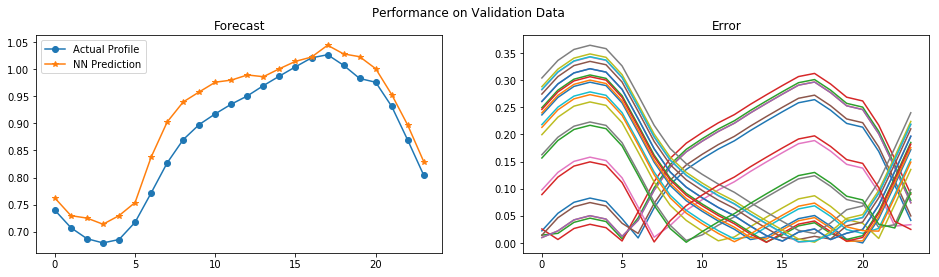

In [289]:
Y_pred = model.predict(X_valid)

fig, axes = plt.subplots(figsize = (16,4), nrows = 1, ncols = 2)

n_plot = np.random.randint(0, Y_pred.shape[0]-1)

fig.suptitle("Performance on Validation Data")

axes[0].plot(Y_valid[n_plot,:], marker = "o", label = "Actual Profile")
axes[0].plot(Y_pred[n_plot,:], marker = "*", label = "NN Prediction")
axes[0].legend()
axes[0].set_title("Forecast")

axes[1].plot(np.abs(Y_pred[n_plot,:]-Y_valid[n_plot,:]))
axes[1].set_title("Error");

Below, there is a simple comparison of the performance of the trained RNN versus real data and the forecasts predicted by the system operator. It should be underlined that the actual forecast models incorporate more variables such as weather. Therefore, they are more complex than the simple NN that I developed for illustrating the concept. Nevertheless, the RNN seems to have learned the underlying pattern. And here is where I consider we could do something more from the AI side. For example, what if the RNN considers not only the load profiles but also how the power system is connected (i.e., how a change in one point of the system affects the generation at another one). I think that via a deep GNN the underlying AI structure can learn those spatio-temporal dependencies from data without having to embed the physics into the model.

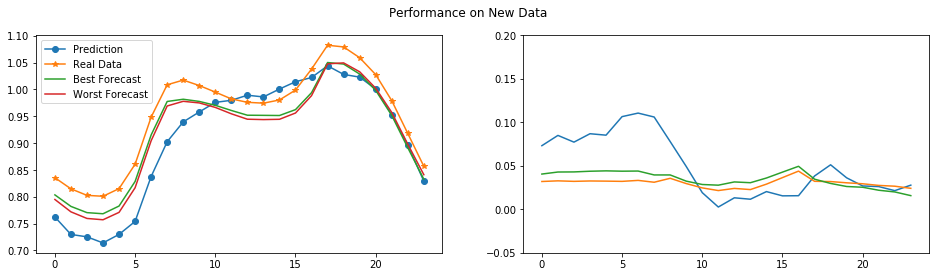

In [277]:
testing_date = "01/09/2020"

_, actual_load, _, _ = get_weekly_behavior(testing_date, "NYISO", data_path = "load_data", show_plot = False)

X_testing = np.array(actual_load)/20000
X_testing = X_testing[np.newaxis, ..., np.newaxis]

Y_pred_new = model.predict(X_testing)[0,:]

time_label, ground_truth, best_fc, worst_fc = visualize_load_forecast(testing_date, "NYISO", data_path = "load_data", show_plot = False)

fig, axes = plt.subplots(figsize = (16,4), nrows = 1, ncols = 2)

fig.suptitle("Performance on New Data")

axes[0].plot(Y_pred_new, label = "NN Prediction", marker = "o")
axes[0].plot(np.array(ground_truth)/20000, label = "Real Data", marker = "*")
axes[0].plot(np.array(best_fc)/20000, label = "Best Forecast")
axes[0].plot(np.array(worst_fc)/20000, label = "Worst Forecast")
axes[0].legend()
axes[0].set_title([])

axes[1].plot(np.abs(np.array(ground_truth)/20000 - Y_pred_new))
axes[1].plot(np.abs(ground_truth - np.array(best_fc))/20000)
axes[1].plot(np.abs(ground_truth - np.array(worst_fc))/20000)
axes[1].set_ylim([-0.05, 0.2]);

## Ideas

(*Context for Application*) We could propose a graph $\mathcal{G} = \left(\mathcal{V}, \mathcal{E}, \mathcal{W}\right)$ that represents a power system. The graph does not need to correspond to an actual grid. Let $N$ be the number of nodes in the graph. 

Assume there are $n_{\ell}<N$ loads and $n_{g}<N$ generators. Note that we can have zero-injection nodes as well (i.e., nodes that are neither generators nor loads). Then, it holds that $n_g + n_{\ell} < N$. Let $\mathcal{N}_g$ be the set of generation nodes ($\mathcal{N_g} \subset \mathcal{V}$) and $\mathcal{N_{\ell}}$ be the set of loading nodes ($\mathcal{N}_{\ell} \subset \mathcal{V}$). Furthermore, assume $\mathcal{N_{g}}$ and $\mathcal{N}_{\ell}$ are disjoint (i.e., no generation node has loads and viceversa).

Since electrical energy must be preserved, it follows that the sum of consumed (loads) power and generation must be equal
$$P_G = P_L$$ 
where $$P_G = \sum_{n_j\in \mathcal{N}_{g}} P_{g}^{j}$$ 
and 
$$P_L = \sum_{n_i \in \mathcal{N}_{\ell}} P_{\ell}^{i}$$

- **Problem:** we have access to actual load profiles from NYISO (the state agency responsible for operating the transmission system in NY). This data is preprocessed and organized by region. However, we do not have real generation profiles. Despite this, we can generate the generation profiles for a fictitious system using the previous equations and allocating $P_G$ in the generators of the systems.
    
To each of the nodes we can assign a load/generation profile (i.e., the $i$th node will consume $P_{\ell}^{i}$ and the $j$th generator will inject $P_{g}^{j}$. At each time instant, the sum of the loads correspond to the sum of the generators. Since this characteristic will be frequent in every instance in the training set, this feature is something that should be learned by the GNN. It could be verified after training. 
    
(*AI Contribution*) The idea of using a different type of cell could improve the performance of the RNN since it could enhance its expressivity.

From the signal processing perspective, what we are trying to do is to reconstruct a signal from data. I have the feeling that it can be shown (perhaps it has been done but I am not aware of it) that LSTMs represent a particular basis to reconstruct the signal. Legendre Memory Units could be seen as another basis to reconstruct time signals (see [this link](https://www.math.lsu.edu/system/files/MD1%20Paper.pdf) and [this one](https://math.stackexchange.com/questions/283021/legendre-polynomials-laguerre-polynomials-basic-concept)). There are another particular family of orthogonal polynomials that could be used as a basis for an RNN: Laguerre functions. Laguerre functions have been used as building blocks for Model Predictive Control (MPC) strategies. MPC is a control paradigm based on real-time optimization. I have noticed that there is a similar structure between a MPC strategy and an RNN: the MPC architecture uses actual information to forecast the behavior of the system in a fixed-time horizon and then use that information to compute a set of control moves $\Delta u_i$. An RNN uses historical data to make predictions, but the optimization problem takes place offline (all training data is available instead of being generated parallel to the evolution of the network). 

With this in mind, I have the feeling it could be possible to develop a Laguerre-like memory cell prototype. This could be time consuming and I am not sure whether the time we have remaining would be enough to develop it. Alternatively, we could try to develop the GNN architecture using the existing Legendre Memory Unit and justify its use from the change-of-basis perspective.